# Tema 6 Tecnologías del Habla


#### Rebeca Goya Esteban y Óscar Barquero Pérez
Adaptado de: Introduction to Pattern Recognition  A MATLAB \textregistered Approach.
Sergios Theodoridis, Aggelos Pikrakis, Konstantinos Koutroumbas, Dionisis Cavouras.
Elservier 2010.

update: 10 de noviembre de 2023

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-CompartirIgual 4.0 Internacional</a>. 

### Dynamic Time Warping (DTW) para reconocimiento del habla

Nota: el dtwend no funciona al inicio.

Nos vamos a centrar en una tarea sencilla de reconocimiento del habla: *reconocimiento de palabras aisladas (RPA)*. 
Este sistema RPA consiste en un conjunto de **patrones de referencia** y una **medida de distancia**. El reconocimiento de una **palabra de test** (entrada que reconoce el sistema) se consigue encontrando el mejor ajuste entre la palabra de test y cada uno de los patrones de referencia en base a la medida de distancia considerada.

Si tenemos dos secuencias se puede utilizar su distancia euclídea para cuantificar su similaridad. Si las secuencias tienen diferente longitud, una forma de poder calcular la distancia entre ellas es permitir comprensiones o extensiones locales (*warping*), este efecto se consigue construyendo el camino óptimo a través de los nodos de una rejilla. La rejilla se construye a partir de las dos secuencias en un espacio bidimensional situando una secuencia en el eje horizontal y otra en el eje vertical. Si colocamos la secuencia de referencia en el eje horizontal, las dimensiones de la rejilla son $JxI$, donde $I$ y $J$ son las longitudes de las secuencias de test y de referencia respectivamente. El tipo y el grado permitido de comprensión/expansión se determina mediante las llamadas restricciones locales. Son muy utilizadas las restricciones Sakoe-Chiba. Básicamente son restricciones para los posibles saltos entre los nodos de la rejilla. 

Como paso previo para comprender mejor la utilización de DTW para reconocimiento del habla vamos a trabajar con secuencias de números. 


* Sea $P = [-1,-2,0,2]$ la secuencia patrón de referencia $T = [-1,-2,-2,0,2]$ la secuencia de test. **Obtenga el camino óptimo y su distancia acumulada** adoptando las restricciones locales de Sakoe-Chiba. Utilice para ello la función *dtw* de tds_dtw_utils.py, fíjese en los parámetros de entrada y de salida. 
* Repita para $T = [-1,-2,-2,-2,-2,0,2]$

Como T difiere de P únicamente en términos de repetición de un símbolo, la longitud de la repetición no afecta al distancia acumulada, sólo causa más o menos efecto de compresión en el camino. Análogamente en habla podemos tener la misma palabra pero una vez pronunciada más rápido y otra más despacio. Segmentos verticales u horizontales largos son habituales cuando se emplean las restricciones locales de Sakoe-Chiba. Para evitar que estos segmentos sean indefinidamente largos se pueden utilizar restricciones globales.

* Repita para T = [-1,-2,-3,0,2,3], ¿qué diferencia hay en este caso?.


También se pueden especificar restricciones de extremos. Para explorar la importancia de estas restricciones, dada la secuencia patrón P = [-8,-4,0,4,0,-4] y la secuencia de test T =[0,-8,-4,0,4,0,-4,0,0]:

* Obtenga el camino óptimo y su distancia acumulada adoptando las restricciones locales de Sakoe-Chiba.

A pesar de que P y T son prácticamente iguales, sólo difieren en los ceros al principio y al final de T la distancia acumulada no es nula. Esta es una situación común, que haya *basura* cerca de los extremos, para solucionarlo se pueden incluir restricciones de extremos que sirven para poder omitir un determinado número de símbolos al principio y al final de la secuencia de test.

* Pruebe a utilizar las restricciones de extremos en el ejemplo anterior con la función *DTWSakoeEndp*, fíjese en los parámetros de entrada de la función y permita omitir hasta dos símbolos tanto al inicio como al final de la secuencia de test.

Las restricciones de extremos son muy útiles en reconocimiento del habla porque las palabras de test pueden contener periodos de silencio alrededor de los extremos, mientras que los patrones de referencia almacenados en el sistema no.
itemize

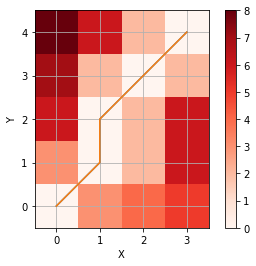

In [7]:
from tds_dtw_utils import *

#p = np.array([-8,-4,0,4,0,-4])
#t = np.array([0,0,-8,-4,0,4,0,-4,0,0])

p = np.array([1,-2,0,2])
t = np.array([1,-2,-2,0,2])

NodeCost, accumulated_cost, path, cost, matching_cost = dtw(p,t,dist = 'euclidean')
#NodeCost, accumulated_cost, path, cost, matching_cost = dtw_Endp(p,t,dist = 'euclidean',omit_left = 2,omit_right = 2,warp = 1)


plt.figure()

distance_cost_plot(accumulated_cost,path)
path_y = [point[0] for point in path]
path_x = [point[1] for point in path]
plt.plot(path_x,path_y)

In [8]:
print(cost)

0.0




Ahora vamos explorar un sistema simple de reconocimiento de palabras aisladas, el sistema tendrá un vocabulario de 10 palabras: zero,one,two...nine. Se trata de un sistema de reconocimiento de palabras aisladas. Necesitamos por lo tanto 10 patrones de referencia uno por cada palabra que es capaz de reconocer el sistema. Los archivos .wav que vamos a utilizar como patrones de referencia, asi como las grabaciones de las palabras de test se encuentrán en la carpeta **data**. Los patrones de referencia están nombrados como zero.wav, one.wav, etc., y las palabras de test están nombradas como **upatternxy.wav**, donde **x** indica el dígito pronunciado por el locutor e **y** indica el número de repetición.

* Pruebe a reproducir algunos de los patrones de referencia y algunos de los patrones de test.

In [3]:
import scipy.io.wavfile as wf
import IPython.display as ipd

filename = 'upattern01.wav'

fs,y = wf.read(filename)
ipd.Audio(y,rate=fs)

En una primera etapa, un algoritmo de extracción de características convierte la señal de voz en una secuencia de vectores de características. Para construir este sistema utilizamos dos características: la energía localizada y la tasa de cruces por cero localizada (utilizamos sólo estas dos características por simplicidad).

En la función **obtainPatterns.m** se extraen las características de los patrones de referencia. Analice esta función:


* ¿Qué recorre el bucle for?¿qué realizan cada una de las instrucciones del bucle?.
* ¿Cuál es el tamaño de la ventana de análisis de la señal de voz?¿por qué tiene este tamaño?.

In [3]:
def obtainPatterns():
    
    protoFSeq = []
    protoNames=['zero.wav','one.wav','two.wav','three.wav','four.wav','five.wav','six.wav','seven.wav'
                ,'eight.wav','nine.wav']
    for fname in protoNames:
        fs, x = wf.read(fname)
        winlength = int(np.round(0.02*fs))
        w = sig.boxcar(winlength)
        winstep = winlength # moving window step. No overlap
        e = energia2(x,w)
        Zcr = zcr2(x,w)
        protoFSeq.append(np.array([e,Zcr]))
    
    return protoFSeq


* Ejecute la función: ¿Qué contiene protoFSeq?
* ¿En cuantas tramas se ha dividido la señal correspondiente a la palabra five?  

In [4]:
from tds_dtw_utils import *
#import os
#os.chdir("../")
#os.chdir("../data")
protoFSeq = obtainPatterns()
print(protoFSeq[5])
print(len(protoFSeq))


[[0.00884464 0.00496068 0.00693634 0.00859507 0.01161954 0.01177709
  0.09484706 0.38351677 0.56497021 0.83323996 0.96722299 1.
  0.9684636  0.77654624 0.62234641 0.67684542 0.76184426 0.44535067
  0.56210184 0.64635446 0.26715668 0.11729989 0.05919492 0.02958694
  0.0123176  0.01930388 0.01440097 0.00473375 0.01742102 0.00739272
  0.01843175]
 [0.1        0.159375   0.125      0.125      0.153125   0.121875
  0.059375   0.0625     0.08125    0.090625   0.09375    0.0875
  0.084375   0.103125   0.096875   0.109375   0.084375   0.075
  0.090625   0.075      0.078125   0.053125   0.040625   0.06875
  0.084375   0.075      0.0625     0.1125     0.06875    0.08125
  0.025     ]]
10


Examine la función **IsoDigitRec.m**


* Localice dónde se lee la palabra de test (la palabra a reconocer) y dónde se hace la extración de características de esta palabra.
* Localice dónde se utiliza DTW para el reconocimiento de las palabras. ¿Qué recorre el bucle?. Introduzca los dos primeros parámetros (sustituir por a y b) cuando se llama a la función **DTWSakoeEndp** de forma que el primer parámetro sea el conjunto de vectores de características de cada uno de los patrones de referencia (será uno en cada iteración del bucle) y el segundo parámetro sea el conjunto de vectores de características de la palabra de test (este será el mismo para todas las iteraciones del blucle).  
* Ejecute el script para una palabra de test. Una vez calculado el coste o distancia del camino óptimo respecto a cada uno de los patrones de referencia ¿cómo decide el sistema cuál es la palabra de entrada al sistema?
* Ejecute el script para todas las palabras de test. Compruebe si los resultados son correctos.

In [21]:
def IsoDigitRec(protoFSeq, patt_to_rec = 'upattern01'):

    protoNames=['zero.wav','one.wav','two.wav','three.wav','four.wav','five.wav','six.wav','seven.wav'
                ,'eight.wav','nine.wav']
    #Read audio test: to recognize
    fs, test = wf.read(patt_to_rec)
    winlength = int(np.round(0.02 * fs)) #use the same values as before
    
    w = sig.boxcar(winlength)
    winstep = winlength # moving window step. No overlap
    
    #compute features for test audio
    e = energia2(test,w)
    Zcr = zcr2(test,w)
    #Create a vector
    Ftest=np.array([e,Zcr])
    
    tolerance=0.1 #tolerance for remove endpoints
    LeftEndConstr= int(np.round(tolerance/winstep)) # left endpoint constraint
    RightEndConstr = LeftEndConstr
    
    matchingcost = []
    cost = []
    for proto in protoFSeq:
       
        NodeCost, D, path, cost_a, matching_cost_a = dtw_Endp(proto.T,Ftest.T,omit_left=LeftEndConstr,
                                                              omit_right=RightEndConstr)
        
        cost.append(cost_a)
        matchingcost.append(matching_cost_a)
        
        
    indexofBest = np.argmin(matchingcost);
    print(indexofBest)
    print(matchingcost)


    print('The unknown pattern has been identified as a "%s" \n'%(protoNames[indexofBest]))


In [26]:
#os.chdir("../")
#os.chdir("./data")

IsoDigitRec(protoFSeq, patt_to_rec = 'upattern22.wav')


2
[0.056085111607984135, 0.07219397198077104, 0.04249041158838586, 0.04274097129583531, 0.05970146335684157, 0.05885586081961771, 0.09089570658121597, 0.12070981124345602, 0.07197300784193061, 0.06841506484528835]
The unknown pattern has been identified as a "two.wav" 



**Bibiliografía**

Introduction to Pattern Recognition 
A MATLAB \textregistered Approach.
Sergios Theodoridis, Aggelos Pikrakis, Konstantinos Koutroumbas, Dionisis Cavouras.
Elservier 2010.